In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Sep  9 04:25:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Retinanet

https://airctic.com/retinanet/

Retinanet is proving very tricky to train

In [ ]:
!wget https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip -q

In [ ]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
   creating: fire-dataset/
   creating: fire-dataset/train/
   creating: fire-dataset/train/annotations/
  inflating: fire-dataset/train/annotations/img (100).xml  
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inflating: fire-dataset/train/annotations/img (113).xml  
  inflating: fire-dataset/tr

In [ ]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [ ]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [ ]:
!rm  -r fire-dataset/validation/

In [ ]:
!ls fire-dataset/train

annotations  images


In [ ]:
# !pip install  icedata
# !pip install icevision[all]
# !pip install git+git://github.com/airctic/icedata.git@master
# !pip install git+git://github.com/airctic/icevision.git@master

!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

--2021-09-09 04:26:27--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244 (1.2K) [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]   1.21K  --.-KB/s    in 0s      

2021-09-09 04:26:27 (63.4 MB/s) - ‘install_colab.sh’ saved [1244/1244]

Installing icevision + dependencices for CUDA 10
Uninstalling some dependencies to prevent errors
Found existing installation: torchvision 0.10.0+cu102
Uninstalling torchvision-0.10.0+cu102:
  Successfully uninstalled torchvision-0.10.0+cu102
Found existing installation: fastai 1.0.61
Uninstalling fastai-1.0.61:
  Successfully uninstalled fastai-1.0.61
Installing some dependencies to prevent errors
     |██

In [ ]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


In [ ]:
import matplotlib.pyplot as plt
import icevision
icevision.__version__

'0.8.1'

In [ ]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [ ]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [ ]:
image_files = [i for i in images_dir.glob('*')]
image_files[:3]

[Path('fire-dataset/train/images/pic (205).jpg'),
 Path('fire-dataset/train/images/pic (35).jpg'),
 Path('fire-dataset/train/images/pic (43).jpg')]

In [ ]:
annotation_files = [i for i in annotations_dir.glob('*')]
annotation_files[:3]

[Path('fire-dataset/train/annotations/small (60).xml'),
 Path('fire-dataset/train/annotations/small (102).xml'),
 Path('fire-dataset/train/annotations/small (39).xml')]

In [ ]:
class_map = ClassMap(['fire'])

In [ ]:
parser = parsers.VOCBBoxParser(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)
parser.class_map

<ClassMap: {'background': 0, 'fire': 1}>

In [ ]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

  0%|          | 0/502 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
# objects = aggregate_records_objects(train_records + valid_records)

In [ ]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
model_type = models.torchvision.retinanet
backbone = model_type.backbones.resnet50_fpn

In [ ]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

Each model has its own dataloader (a pytorch `DataLoader`) that could be customized: the dataloaders for the RCNN models have a custom collate function.

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=9.120108734350652e-05)

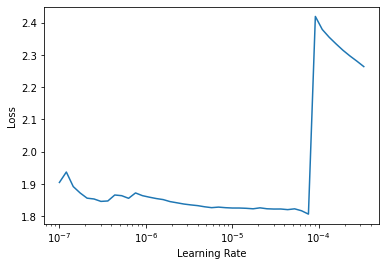

In [ ]:
learn.lr_find()

The fastai fine_tune method is useful when you have a pre-trained model, which we are using. It does an initial epoch where it freezes everything except its final layers. It then carries on for the indicated number of epochs using a differential learning rate to train the whole model. It adjusts the learning rate both across the layers of the model as well as across the epochs. This can give excellent results with reduced training time.

In [ ]:
learn.fine_tune(50, 5e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.235121,1.625486,0.000330,00:36


epoch,train_loss,valid_loss,COCOMetric,time
0,1.018306,1.057989,0.057366,00:55
1,0.940753,0.997152,0.073451,00:54
2,0.887405,0.923695,0.084086,00:55
3,0.858676,0.968810,0.171532,00:53
4,0.829878,0.915041,0.151991,00:54
5,0.828752,0.965671,0.153880,00:54
6,0.800548,0.896044,0.153704,00:54
7,0.806745,0.958595,0.151895,00:54
8,0.786306,0.883861,0.159456,00:54
9,0.782108,1.056507,0.132529,00:54


At 50 epochs reaching 0.325670

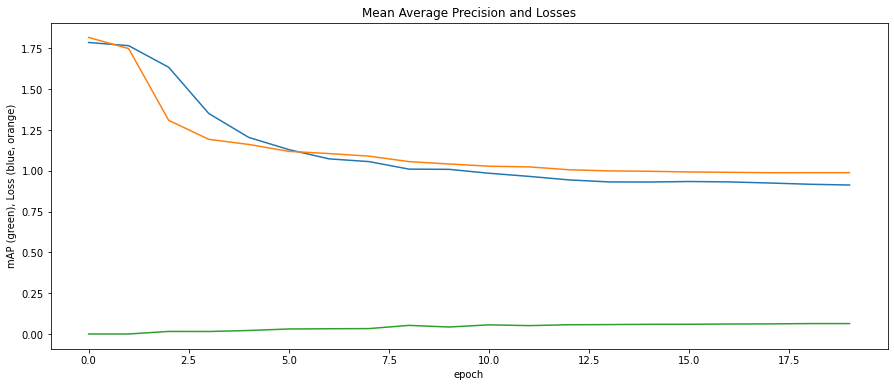

In [ ]:

def plot_metrics(learn, title, x, y):
  fig, ax = plt.subplots(1,1,figsize=(15,6))
  ax.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)

plot_metrics(learn, 'Mean Average Precision and Losses', 0,-0.05)

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/26 [00:00<?, ?it/s]

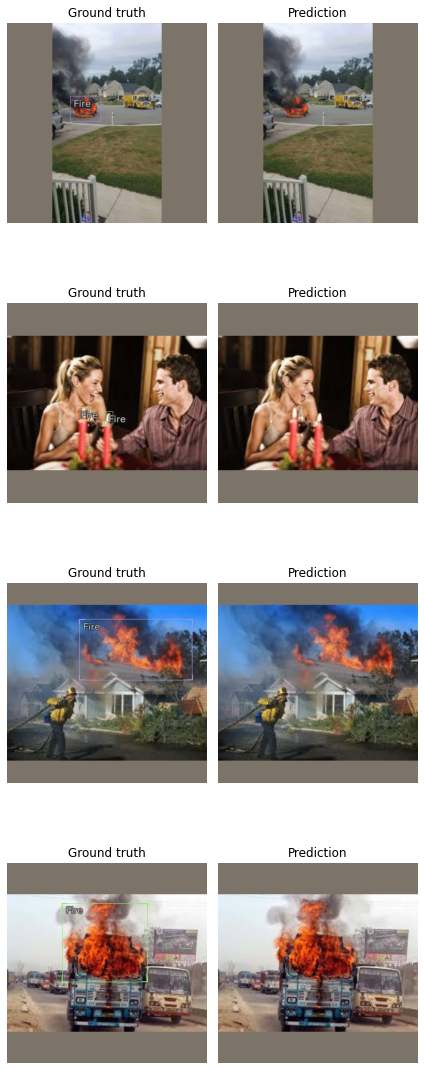

In [ ]:
show_preds(preds=preds[:4])

https://airctic.github.io/icedata/how-to/#how-to-save-trained-weights-in-google-colab

In [ ]:

# ## Saving a Model on Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = Path('/content/gdrive/My Drive/')

# torch.save(model.state_dict(), root_dir/'models/icedata/retinanet_fire.pth')